In [1]:
building_id = 2
price = 108
iteration = 33  
# we are ready to run!

In [2]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = 'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = 'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)



# Weather file
epw_file   = 'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = 'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [3]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
error_dir  = 'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(output_dir)

# EHUB
ehub_dir   = 'ehub/output_ehub_excel/' + "{}-{}-{}/".format(building_id,price,iteration)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = "rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106
ga_proc = ga_output_dir + "panel_{}_sing_processed.xlsx".format(price)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML


# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [6]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir, 
                                   epw_file=epw_file, err_dir=error_dir) 

/home/user/.local/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## the North Axis
The north axis gets grabbed automatically from the idf.

In [7]:
pvbuilding.North_Axis

0.0

In [8]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0,                        !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [9]:
# Determine the hourly electricity use
pvbuilding.run_ep()

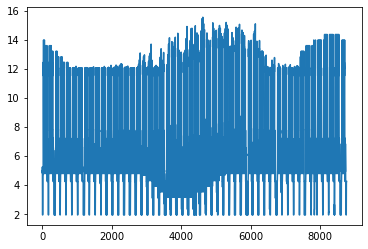

In [10]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [11]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.63
14.35220436334519


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [12]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 599 m2
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [13]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 3.8857719898223877 sec
ERROR:root:Finished Generation of Irradiance
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 3.300262451171875 sec
ERROR:root:Finished Generation of Irradiance


0.0


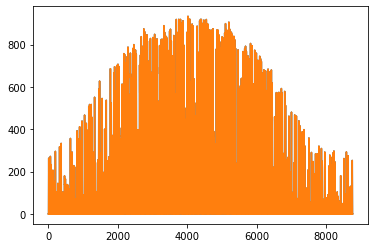

In [14]:
pan_vals = (90,90,90,1,1,1,0.2,0.2,0.2)

irr1 = pvpanel.irradiance(90,1,0.2,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(90,1,0.2,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


In [15]:
from pv_model import pvModel
# These are the fixed five panels that we are interested in
if (number_of_panels==5):
    azi = [180,215,245,215,130]
    tilt = [35,55,10,35,5]
    gcr = [0.6,0.35,0.9,0.7,0.9]
# These are the fixed three panels that we are interested in
if (number_of_panels==3):
    azi = [180,215,245]
    tilt = [35,55,10]
    gcr = [0.9,0.35,0.9]
# Setup the values array
pan_vals = []
pan_vals.extend(azi)
pan_vals.extend(tilt)
pan_vals.extend(gcr)

pan_vals =(90,90,90,1,1,1,0.2,0.2,0.2)

print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels)

(90, 90, 90, 1, 1, 1, 0.2, 0.2, 0.2)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


In [16]:
my_model.eval_model(pan_vals,106,pvpanel)

ERROR:ga_logger:panel values: (90, 90, 90, 1, 1, 1, 0.2, 0.2, 0.2)
ERROR:ga_logger:price of the panel 106
ERROR:ga_logger:Start Evaluation
ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.200
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 3.497173309326172 sec
ERROR:root:Finished Generation of Irradiance
ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 90
                                           a tilt of 1.0
                                           and a gcr of 0.200
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 3.3726727962493896 sec
ERROR:root:Finished Generation of Irradiance
ERROR:ga_logger:Compiling and setting: Irra2 based on:
       

Total Electricity Imported from the grid 51,302 kWh
At a cost of $ 0.0972 /kWh
Total Cost of the system: $ 6,308 per year


Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%


After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [17]:
my_model.energyIm

51302.5

In [18]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [19]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         3724.04
Aug         4466.82
Dec         4970.85
Feb         4166.99
Jan         4963.20
Jul         3803.84
Jun         3716.46
Mar         4462.39
May         3726.09
Nov         4723.31
Oct         4548.28
Sep         4030.26
monthly_import    51302.53
dtype: float64
51302.5
     monthly_export
Apr       1373.2100
Aug       1728.0800
Dec         46.8434
Feb        244.7710
Jan         61.5436
Jul       2264.6100
Jun       1815.4500
Mar        625.6940
May       1849.9900
Nov         72.3804
Oct        369.3260
Sep       1059.0800
monthly_export    11510.9784
dtype: float64
11511.0
133.042


In [20]:
my_model.solveResults['solution']['daily_charge_c']

133.042

In [21]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             1
Grid                 1
Invertor             1
PV0                  1
PV1                  0
PV2                  0

In [22]:
my_model.solveResults['solution']['any_above_35']

0

In [23]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [24]:
# preload the excel
from pyehub.excel_to_request_format import convert

request_format = convert(excel_file=ehub_file)

In [25]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [26]:
ga_file = ga_output_dir + "panel_{}_sing.xlsx".format(price)
ga_proc = ga_output_dir + "panel_{}_archive_sing.xlsx".format(price)
ga_fina = ga_output_dir + "panel_{}_proccessed_sing.xlsx".format(price)

ERROR:optimizer_logger:Found the solver set
/home/user/.local/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)
ERROR:optimizer_logger:The number of evaluations is 6


[90.  90.  90.   1.   1.   1.   0.2  0.2  0.2] [265.  265.  265.   56.   56.   56.    0.9   0.9   0.9] ['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R']


ERROR:ga_logger:panel values: (184.89535102587783, 109.30495145200905, 226.79935150173935, 35.48117880108882, 38.79736700703574, 55.013841714157095, 0.40591830976259324, 0.7255751182618122, 0.8453815370456388)
ERROR:ga_logger:price of the panel 108
ERROR:ga_logger:Start Evaluation
ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 35.5
                                           and a gcr of 0.406
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 4.171654462814331 sec
ERROR:root:Finished Generation of Irradiance
ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 109
                                           a tilt of 38.8
                                           and a gcr of 0.726
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculati

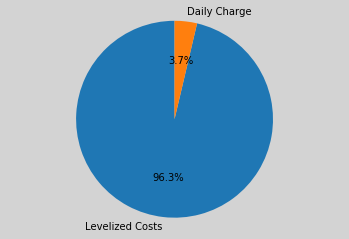

ERROR:ga_logger:panel values: (264.77172229473035, 179.04637061875968, 176.6002455147458, 53.44803631612249, 4.285314981544922, 11.747761645573972, 0.6688782834791014, 0.49267409642564586, 0.5020188067493427)
ERROR:ga_logger:price of the panel 108
ERROR:ga_logger:Start Evaluation
ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 265
                                           a tilt of 53.4
                                           and a gcr of 0.669
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 3.9870688915252686 sec
ERROR:root:Finished Generation of Irradiance
ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 179
                                           a tilt of 4.3
                                           and a gcr of 0.493
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculatio

ERROR:ga_logger:panel values: (215.76202079409967, 225.83756777790163, 133.40635180233483, 16.356740304354126, 45.84438131850058, 24.668310199085347, 0.5947992118419594, 0.8119932423915701, 0.21066437250270792)
ERROR:ga_logger:price of the panel 108
ERROR:ga_logger:Start Evaluation
ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 216
                                           a tilt of 16.4
                                           and a gcr of 0.595
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 4.384063005447388 sec
ERROR:root:Finished Generation of Irradiance
ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 226
                                           a tilt of 45.8
                                           and a gcr of 0.812
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculat

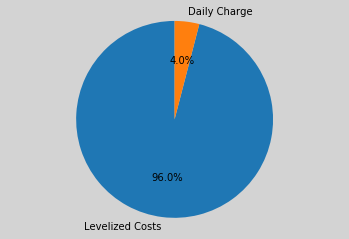

ERROR:ga_logger:panel values: (140.72203425300364, 147.266105821264, 101.16016596925634, 7.245813814464572, 17.713497090076412, 22.615562044054357, 0.8612735779277094, 0.38702109620940456, 0.6723056703236323)
ERROR:ga_logger:price of the panel 108
ERROR:ga_logger:Start Evaluation
ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 141
                                           a tilt of 7.2
                                           and a gcr of 0.861
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 3.9927308559417725 sec
ERROR:root:Finished Generation of Irradiance
ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 147
                                           a tilt of 17.7
                                           and a gcr of 0.387
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculatio

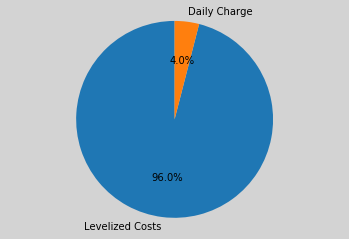

ERROR:ga_logger:panel values: (107.61222167360958, 234.60686409653383, 246.3435046293125, 24.872294631372874, 28.83419291316298, 44.512588793607755, 0.2351696868317973, 0.3163825358737471, 0.3455679911247233)
ERROR:ga_logger:price of the panel 108
ERROR:ga_logger:Start Evaluation
ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 108
                                           a tilt of 24.9
                                           and a gcr of 0.235
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 4.059560775756836 sec
ERROR:root:Finished Generation of Irradiance
ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 28.8
                                           and a gcr of 0.316
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculatio

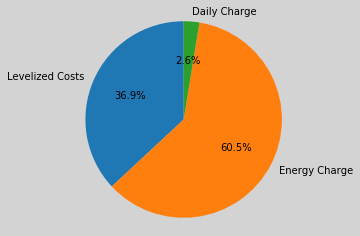

ERROR:ga_logger:panel values: (177.5, 177.5, 177.5, 28.5, 28.5, 28.5, 0.5499999999999999, 0.5499999999999999, 0.5499999999999999)
ERROR:ga_logger:price of the panel 108
ERROR:ga_logger:Start Evaluation
ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 4.155756235122681 sec
ERROR:root:Finished Generation of Irradiance
ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 178
                                           a tilt of 28.5
                                           and a gcr of 0.550
ERROR:root:Started Generation of Irradiance
INFO:pvfactors.run:Parallel calculation elapsed time: 4.313809156417847 sec
ERROR:root:Finished Generation of Irradia

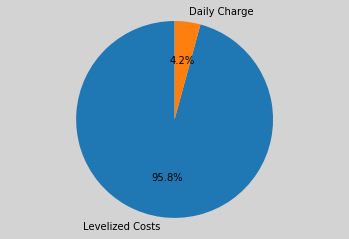

ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 108}


In [27]:
solver_settings = {
                    'name': 'glpk',
                    'options': {
                                'mipgap': 0.05,
                               },
                    }

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                 range_tilt=range_tilt,
                 range_gcr=range_gcr,
                 pvpanel=pvpanel,
                 price=price,
                 store_file=ga_file,
                 ehub_request=request_format,
                 res_file=res_file,
                 pvbuilding=pvbuilding,
                 roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                 ga_proc=ga_proc,
                 solver_settings=solver_settings)
pvoptimizer.runRBFOPT(6, model="BC",obj="SINGLE-NET")
pvoptimizer.processGA(ga_fina)